In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 경고 뜨지 않게
import warnings
warnings.filterwarnings('ignore')

### bureau.csv

In [2]:
# CSV 파일 불러오기
bureau = pd.read_csv("archive/bureau.csv")
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [3]:
# 1. 외부 대출 현황 관련 파생 변수

# 현재 활성화된 대출 여부
bureau['IS_ACTIVE'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)

# 총 부채 / 총 대출 비율
bureau['DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

# 대출 총합 / 부채 총합 (파생변수는 아니지만 집계용으로 유지)
# bureau['AMT_CREDIT_SUM'], bureau['AMT_CREDIT_SUM_DEBT']

# 현재 연체 금액
# bureau['AMT_CREDIT_SUM_OVERDUE'] 그대로 사용

# 대출 연장 여부
bureau['HAS_PROLONGED'] = (bureau['CNT_CREDIT_PROLONG'] > 0).astype(int)\

# 현재 부채가 있는 대출 여부
bureau['HAS_DEBT'] = (bureau['AMT_CREDIT_SUM_DEBT'] > 0).astype(int)

In [4]:
# 2. 연체/이력 관련 파생 변수

# 연체 경험 여부
bureau['HAS_OVERDUE'] = (bureau['AMT_CREDIT_SUM_OVERDUE'] > 0).astype(int)
bureau['DEBT_RATIO'] = bureau['DEBT_RATIO'].replace([float('inf'), -float('inf')], pd.NA)  # 0으로 나눌 시 제거

# 최대 연체 기간
# bureau['CREDIT_DAY_OVERDUE'] 그대로 사용

# 과거 최대 연체금액
# bureau['AMT_CREDIT_MAX_OVERDUE'] 그대로 사용

# 단기 연체 여부 (7일 이상, 90일 이하)
bureau['IS_OVERDUE_SHORT'] = ((bureau['CREDIT_DAY_OVERDUE'] >= 7) & (bureau['CREDIT_DAY_OVERDUE'] <= 90)).astype(int)

# 장기 연체 여부 (90일 이상)
bureau['IS_OVERDUE_LONG'] = (bureau['CREDIT_DAY_OVERDUE'] >= 90).astype(int)

In [5]:
# 고객(SK_ID_CURR) 단위로 '연체 경험이 있는지' 여부 계산
overdue_by_cust = bureau.groupby('SK_ID_CURR')[['IS_OVERDUE_SHORT', 'IS_OVERDUE_LONG']].max().reset_index()

# 전체 고객 수
total_customers = overdue_by_cust.shape[0]

# 각각 연체 유형별로 연체 고객 수
short_overdue_cnt = overdue_by_cust['IS_OVERDUE_SHORT'].sum()
long_overdue_cnt = overdue_by_cust['IS_OVERDUE_LONG'].sum()

# 각각 비율 계산
short_overdue_pct = short_overdue_cnt / total_customers
long_overdue_pct = long_overdue_cnt / total_customers

# 결과 출력
print(f"총 고객 수: {total_customers:,}")
print(f"단기 연체 경험 고객 수: {int(short_overdue_cnt):,} ({short_overdue_pct:.2%})")
print(f"장기 연체 경험 고객 수: {int(long_overdue_cnt):,} ({long_overdue_pct:.2%})")

총 고객 수: 305,811
단기 연체 경험 고객 수: 2,511 (0.82%)
장기 연체 경험 고객 수: 1,233 (0.40%)


In [6]:
# 3. 종료/잔여 기간 관련 파생 변수
# 잔여기간이 남은 대출
bureau['IS_REMAINING'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)

# 종료일 존재 여부 (정보 누락 방지용)
bureau['HAS_ENDDATE_FACT'] = bureau['DAYS_ENDDATE_FACT'].notnull().astype(int)

# 장기(예: 1년+) 잔여기간인 활성 대출 여부 ,고객 단위 KPI 추출
bureau['IS_LONG_TERM_ACTIVE'] = ((bureau['CREDIT_ACTIVE'] == 'Active') & (bureau['DAYS_CREDIT_ENDDATE'] > 365)).astype(int)
kpi = bureau.groupby('SK_ID_CURR')['IS_LONG_TERM_ACTIVE'].mean().reset_index()

# application에 병합
app = pd.read_csv("archive/application_train.csv")
app = app.merge(kpi, on='SK_ID_CURR', how='left')
app.to_csv("application_kpi.csv", index=False)

# 대출 종료 여부 (현재 종료 상태인지 여부)
bureau['IS_CLOSED'] = (bureau['CREDIT_ACTIVE'] == 'Closed').astype(int)

# 종료된 대출에 대해서만 실제 종료일과 예정 종료일의 차이 계산
# 결측값 방지용 조건 포함
bureau['DIFF_ENDDATE'] = None
cond = (bureau['IS_CLOSED'] == 1) & bureau['DAYS_ENDDATE_FACT'].notna() & bureau['DAYS_CREDIT_ENDDATE'].notna()
bureau.loc[cond, 'DIFF_ENDDATE'] = bureau.loc[cond, 'DAYS_ENDDATE_FACT'] - bureau.loc[cond, 'DAYS_CREDIT_ENDDATE']

In [7]:
# 실제 종료일과 예정 종료일 차이 통계
bureau['DIFF_ENDDATE'].value_counts()

DIFF_ENDDATE
 0.0        323616
 1.0         34734
-29.0        33056
-28.0        22531
 2.0         12616
             ...  
-5183.0          1
-8419.0          1
-9786.0          1
-31608.0         1
-3050.0          1
Name: count, Length: 10479, dtype: int64

In [8]:
# 조기상환 vs 연체종료 비율

# NaN이 아닌 경우에만 처리
bureau_valid = bureau[bureau['DIFF_ENDDATE'].notna()].copy()

# 종료 상태 분류
bureau_valid['END_STATUS'] = bureau_valid['DIFF_ENDDATE'].apply(
    lambda x: '조기상환' if x < 0 else ('연체종료' if x > 0 else '정시종료')
)

# 비율 출력
bureau_valid['END_STATUS'].value_counts(normalize=True) * 100

bureau = bureau.merge(
    bureau_valid[['SK_ID_BUREAU', 'END_STATUS']],
    on='SK_ID_BUREAU', how='left')

In [9]:
bureau[(bureau['IS_CLOSED'] == 1) & (bureau['END_STATUS'].isna())]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,HAS_DEBT,HAS_OVERDUE,IS_OVERDUE_SHORT,IS_OVERDUE_LONG,IS_REMAINING,HAS_ENDDATE_FACT,IS_LONG_TERM_ACTIVE,IS_CLOSED,DIFF_ENDDATE,END_STATUS
32,136226,5714503,Closed,currency 1,-559,0,NaN,-355.0,0.0,0,...,0,0,0,0,0,1,0,1,None,NaN
179,373324,5714689,Closed,currency 1,-1805,0,NaN,-320.0,0.0,0,...,0,0,0,0,0,1,0,1,None,NaN
206,312983,5714725,Closed,currency 1,-1278,0,NaN,-244.0,0.0,0,...,0,0,0,0,0,1,0,1,None,NaN
383,273814,5714968,Closed,currency 1,-186,0,NaN,-118.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN
409,414912,5715003,Closed,currency 1,-1036,0,NaN,-510.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716093,439575,5047450,Closed,currency 1,-1338,0,NaN,-1324.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN
1716167,419341,5049665,Closed,currency 1,-558,0,NaN,-17.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN
1716209,425720,5051615,Closed,currency 1,-752,0,NaN,-309.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN
1716396,181001,5057529,Closed,currency 1,-339,0,NaN,-163.0,NaN,0,...,0,0,0,0,0,1,0,1,None,NaN


In [10]:
d = pd.read_csv("데이터 파일/application_kpi.csv")
d

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,IS_LONG_TERM_ACTIVE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.125000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.500000
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
# 4. 대출 종류 관련 파생 변수

# 주요 유형 대출 경험 (예: Car, Mortgage)
bureau['IS_CAR_LOAN'] = (bureau['CREDIT_TYPE'] == 'Car').astype(int)
bureau['IS_MORTGAGE_LOAN'] = (bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
bureau['IS_MICRO_LOAN'] = (bureau['CREDIT_TYPE'] == 'Microloan').astype(int)

# 특정 유형 대출 경험자 여부는 위 IS_컬럼으로 판단

def add_overlap_and_credit_increase_features(bureau):
    """
    bureau 데이터프레임에 다음 파생변수를 추가합니다:

    - OVERLAP: 기존 대출이 끝나기 전에 신규 대출을 받은 경우 (True/False)
    - CREDIT_INCREASED: 겹친 상태에서 대출 금액이 증가한 경우 (True/False)
    - DELTA_CREDIT_SUM_IF_INCREASED: 이전보다 대출 금액이 얼마나 증가했는지 (금액 차이)
    - DELTA_CREDIT_PCT_IF_INCREASED: 이전보다 대출 금액이 얼마나 증가했는지 (비율 %)
    - OVERLAP_DAYS: 겹쳐진 대출의 기간 (며칠 겹쳤는지)
    - OVERLAP_YEARS: 겹쳐진 대출의 기간 (연 단위)
    - CREDIT_TERM_DAYS: 각 대출의 전체 예정 기간 (일 단위)
    - CREDIT_TERM_YEARS: 각 대출의 전체 예정 기간 (연 단위)
    - IS_FIRST_LOAN: 해당 고객의 첫 번째 대출인지 여부 (True/False)
    - IS_ONGOING: 종료일이 없어 현재 진행 중인 대출인지 여부 (True/False)
    """
    bureau_sorted = bureau.copy()
    
    # 시작일, 종료일 (신청일 기준 상대적 일 수)
    bureau_sorted['START_DATE'] = bureau_sorted['DAYS_CREDIT']
    bureau_sorted['END_DATE'] = bureau_sorted['DAYS_CREDIT_ENDDATE']

    # 진행 중인 대출 여부 (종료일 없음)
    bureau_sorted['IS_ONGOING'] = bureau_sorted['END_DATE'].isna()
    
    # 고객별로 대출 시작일 기준 정렬
    bureau_sorted = bureau_sorted.sort_values(['SK_ID_CURR', 'START_DATE'])
    
    # 이전 대출 종료일, 대출 금액
    bureau_sorted['PREV_END'] = bureau_sorted.groupby('SK_ID_CURR')['END_DATE'].shift()
    bureau_sorted['PREV_SUM'] = bureau_sorted.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].shift()
    
    # OVERLAP: 기존 대출이 끝나기 전에 신규 대출을 받은 경우
    bureau_sorted['OVERLAP'] = bureau_sorted['START_DATE'] < bureau_sorted['PREV_END']
    
    # CREDIT_INCREASED: 겹친 상태에서 대출 금액이 증가한 경우
    bureau_sorted['CREDIT_INCREASED'] = (
        bureau_sorted['OVERLAP'] & 
        (bureau_sorted['AMT_CREDIT_SUM'] > bureau_sorted['PREV_SUM'])
    )
    
    # DELTA_CREDIT_SUM_IF_INCREASED: 대출 금액 증가분 (금액 차이)
    bureau_sorted['DELTA_CREDIT_SUM_IF_INCREASED'] = bureau_sorted.apply(
        lambda row: row['AMT_CREDIT_SUM'] - row['PREV_SUM'] if row['CREDIT_INCREASED'] else None,
        axis=1
    )
    
    # DELTA_CREDIT_PCT_IF_INCREASED: 대출 금액 증가율 (%)
    bureau_sorted['DELTA_CREDIT_PCT_IF_INCREASED'] = bureau_sorted.apply(
        lambda row: (row['AMT_CREDIT_SUM'] - row['PREV_SUM']) / row['PREV_SUM']
        if row['CREDIT_INCREASED'] and row['PREV_SUM'] not in [0, None] else None,
        axis=1
    )
    
    # OVERLAP 기간 계산 (일 / 연 단위)
    bureau_sorted['OVERLAP_DAYS'] = bureau_sorted['PREV_END'] - bureau_sorted['START_DATE']
    bureau_sorted['OVERLAP_YEARS'] = bureau_sorted['OVERLAP_DAYS'] / 365
    
    # 대출 예정 기간 계산
    bureau_sorted['CREDIT_TERM_DAYS'] = bureau_sorted['END_DATE'] - bureau_sorted['START_DATE']
    bureau_sorted['CREDIT_TERM_YEARS'] = bureau_sorted['CREDIT_TERM_DAYS'] / 365

    # IS_FIRST_LOAN: 이전 대출 금액이 없다면 첫 대출로 간주
    bureau_sorted['IS_FIRST_LOAN'] = bureau_sorted['PREV_SUM'].isna()
    
    # Boolean 컬럼의 NaN을 False로 처리
    bureau_sorted['OVERLAP'] = bureau_sorted['OVERLAP'].fillna(False)
    bureau_sorted['CREDIT_INCREASED'] = bureau_sorted['CREDIT_INCREASED'].fillna(False)

    # 원본에 붙이기
    bureau = bureau.copy()
    cols_to_add = [
        'OVERLAP',                         # 기존 대출이 끝나기 전에 신규 대출을 받은 경우
        'CREDIT_INCREASED',                # 겹치는 상태에서 대출 금액이 증가한 경우
        'DELTA_CREDIT_SUM_IF_INCREASED',   # 대출 금액 증가분 (절대 금액 차이)
        'DELTA_CREDIT_PCT_IF_INCREASED',   # 대출 금액 증가율 (%)	
        'OVERLAP_DAYS',                    # 겹친 기간 (일 단위)
        'OVERLAP_YEARS',                   # 겹친 기간 (연 단위)
        'CREDIT_TERM_DAYS',                # 대출 예정 기간 (일 단위)
        'CREDIT_TERM_YEARS',               # 대출 예정 기간 (연 단위)
        'IS_FIRST_LOAN',                   # 고객의 첫 번째 대출인지 여부
        'IS_ONGOING'                       # 현재 진행 중인 대출인지 여부
    ]
    for col in cols_to_add:
        bureau[col] = bureau_sorted[col]

    return bureau

bureau = add_overlap_and_credit_increase_features(bureau)

In [12]:
print(bureau[[ 'OVERLAP',
        'CREDIT_INCREASED',
        'DELTA_CREDIT_SUM_IF_INCREASED',
        'DELTA_CREDIT_PCT_IF_INCREASED',
        'OVERLAP_DAYS',
        'OVERLAP_YEARS',
        'CREDIT_TERM_DAYS',
        'CREDIT_TERM_YEARS',
        'IS_FIRST_LOAN']])

         OVERLAP  CREDIT_INCREASED  DELTA_CREDIT_SUM_IF_INCREASED  \
0           True             False                            NaN   
1           True              True                        45000.0   
2           True              True                       239323.5   
3           True             False                            NaN   
4          False             False                            NaN   
...          ...               ...                            ...   
1716423     True             False                            NaN   
1716424     True             False                            NaN   
1716425     True             False                            NaN   
1716426    False             False                            NaN   
1716427    False             False                            NaN   

         DELTA_CREDIT_PCT_IF_INCREASED  OVERLAP_DAYS  OVERLAP_YEARS  \
0                                  NaN        1694.0       4.641096   
1                            

In [13]:
# 5. 정보 최신성 KPI

# 정보가 최근 갱신된 여부 (예: 90일 이내)
bureau['IS_RECENT_UPDATE'] = (bureau['DAYS_CREDIT_UPDATE'] >= -90).astype(int)

# 갱신 일자 자체는 원본 사용
# bureau['DAYS_CREDIT_UPDATE']

In [14]:
# KPI용 파생 변수 리스트
kpi_cols = [
    'IS_ACTIVE', 'DEBT_RATIO', 'HAS_PROLONGED', 'HAS_DEBT',
    'IS_OVERDUE_LONG', 'IS_REMAINING', 'IS_LONG_TERM_ACTIVE',
    'IS_MORTGAGE_LOAN', 'IS_CAR_LOAN', 'IS_MICRO_LOAN', 'IS_RECENT_UPDATE'
]

# 고객(SK_ID_CURR) 단위로 평균 집계
bureau_kpi_grouped = bureau.groupby('SK_ID_CURR')[kpi_cols].mean().reset_index()

# 고객 단위 KPI를 bureau에 다시 병합
bureau = bureau.merge(bureau_kpi_grouped, on='SK_ID_CURR', suffixes=('', '_KPI'))

In [15]:
# 고위험 여부 정의 함수
def classify_credit_risk(status):
    return 'High Risk' if status in ['Sold', 'Bad debt'] else 'Non-High Risk'

# bureau에 고위험 여부 파생변수 생성
bureau['CREDIT_RISK_GROUP'] = bureau['CREDIT_ACTIVE'].apply(classify_credit_risk)

# 고객(SK_ID_CURR) 단위로 요약 – 고객이 하나라도 High Risk 대출 있으면 High Risk
risk_flag = bureau.groupby('SK_ID_CURR')['CREDIT_RISK_GROUP'].apply(
    lambda x: 'High Risk' if 'High Risk' in x.values else 'Non-High Risk'
).reset_index().rename(columns={'CREDIT_RISK_GROUP': 'HAS_HIGH_RISK_DEBT'})

# bureau에 다시 병합
bureau = bureau.merge(risk_flag, on='SK_ID_CURR', how='left')
bureau.drop(columns=['CREDIT_RISK_GROUP'], inplace=True)
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,HAS_PROLONGED_KPI,HAS_DEBT_KPI,IS_OVERDUE_LONG_KPI,IS_REMAINING_KPI,IS_LONG_TERM_ACTIVE_KPI,IS_MORTGAGE_LOAN_KPI,IS_CAR_LOAN_KPI,IS_MICRO_LOAN_KPI,IS_RECENT_UPDATE_KPI,HAS_HIGH_RISK_DEBT
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0.0,0.272727,0.0,0.454545,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,0.0,0.272727,0.0,0.454545,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,0.0,0.272727,0.0,0.454545,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,0.0,0.272727,0.0,0.454545,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,0.0,0.272727,0.0,0.454545,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,...,0.0,0.666667,0.0,0.333333,0.000000,0.0,0.0,0.666667,0.666667,Non-High Risk
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,...,0.0,0.363636,0.0,0.545455,0.545455,0.0,0.0,0.000000,0.272727,Non-High Risk
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,...,0.0,0.363636,0.0,0.545455,0.545455,0.0,0.0,0.000000,0.272727,Non-High Risk
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,...,0.0,0.258065,0.0,0.193548,0.161290,0.0,0.0,0.387097,0.419355,Non-High Risk


In [16]:
# 고객 단위로 고위험 여부만 요약
high_risk_by_customer = bureau[['SK_ID_CURR', 'HAS_HIGH_RISK_DEBT']].drop_duplicates()

# 총 고객 수
total_customers = high_risk_by_customer.shape[0]

# 고위험 고객 수
high_risk_cnt = (high_risk_by_customer['HAS_HIGH_RISK_DEBT'] == 'High Risk').sum()
non_high_risk_cnt = total_customers - high_risk_cnt

# 비율 계산
high_risk_pct = high_risk_cnt / total_customers
non_high_risk_pct = non_high_risk_cnt / total_customers

# 출력
print(f"총 고객 수: {total_customers:,}")
print(f"고위험 대출 보유 고객 수: {high_risk_cnt:,} ({high_risk_pct:.2%})")
print(f"비고위험 고객 수: {non_high_risk_cnt:,} ({non_high_risk_pct:.2%})")

총 고객 수: 305,811
고위험 대출 보유 고객 수: 6,039 (1.97%)
비고위험 고객 수: 299,772 (98.03%)


하위 20% 컷오프 (bureau): 2.0


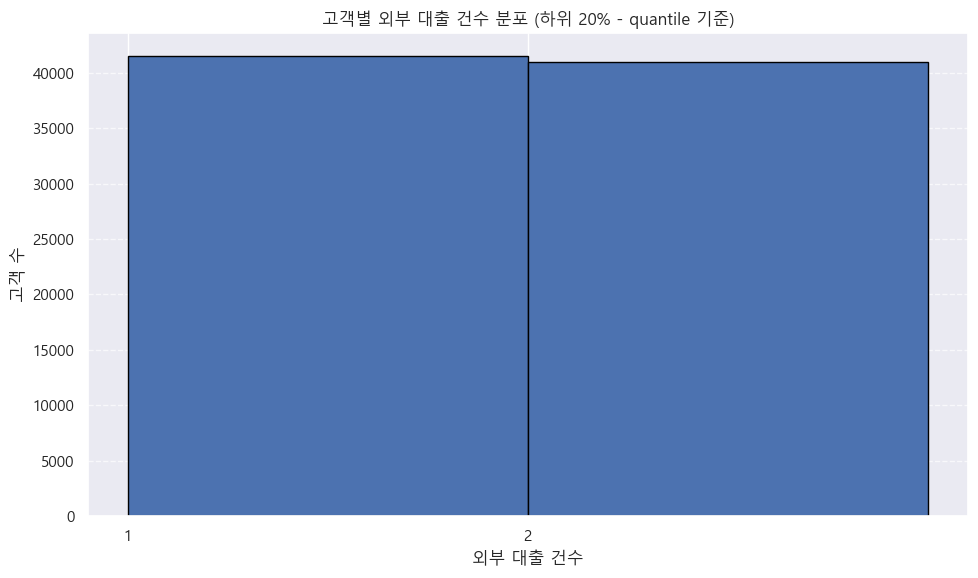

In [17]:
# 고객별 외부 대출 건수
n_bureau = bureau.groupby('SK_ID_CURR').size().reset_index(name='N_BUREAU')

# 1. 하위 20% 컷오프 계산
cutoff_bureau = n_bureau['N_BUREAU'].quantile(0.2)
print(f"하위 20% 컷오프 (bureau): {cutoff_bureau}")

# 2. 플래그 생성
n_bureau['IS_LOW_EXTERNAL_CREDIT'] = (n_bureau['N_BUREAU'] <= cutoff_bureau).astype(int)

# 3. 하위 20% 고객만 필터링
low_20_bureau_users = n_bureau[n_bureau['IS_LOW_EXTERNAL_CREDIT'] == 1]

# 4. 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(low_20_bureau_users['N_BUREAU'], 
         bins=range(int(low_20_bureau_users['N_BUREAU'].min()), int(cutoff_bureau) + 2), 
         edgecolor='black')
plt.title('고객별 외부 대출 건수 분포 (하위 20% - quantile 기준)')
plt.xlabel('외부 대출 건수')
plt.ylabel('고객 수')
plt.xticks(range(int(low_20_bureau_users['N_BUREAU'].min()), int(cutoff_bureau) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
n_bureau['N_BUREAU'].describe()

count    305811.000000
mean          5.612709
std           4.430354
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         116.000000
Name: N_BUREAU, dtype: float64

In [19]:
# bureau에 고객 단위 플래그 병합
bureau = bureau.merge(
    n_bureau[['SK_ID_CURR', 'IS_LOW_EXTERNAL_CREDIT']],
    on='SK_ID_CURR',
    how='left'
)

# 결측값 (대출 기록 없는 고객) → 0으로 처리
bureau['IS_LOW_EXTERNAL_CREDIT'] = bureau['IS_LOW_EXTERNAL_CREDIT'].fillna(0).astype(int)

### bureau_balance.csv

In [20]:
# CSV 파일 불러오기
bureau_b = pd.read_csv("archive/bureau_balance.csv")
bureau_b

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [21]:
# 상태 값 매핑 및 연체 여부 계산
status_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'C': 0, 'X': 0}
bureau_b['STATUS_NUM'] = bureau_b['STATUS'].map(status_map)
bureau_b['IS_OVERDUE'] = bureau_b['STATUS'].isin(['1','2','3','4','5']).astype(int)

In [22]:
# 최근 3년치만 필터링
MONTHS_BALANCE_36 = bureau_b[bureau_b['MONTHS_BALANCE'] >= -36].copy()

In [23]:
# 최근 3년간 연체 상태 유지율
overdue_rate = MONTHS_BALANCE_36.groupby('SK_ID_BUREAU')['IS_OVERDUE'].mean().reset_index()
overdue_rate.rename(columns={'IS_OVERDUE': 'OVERDUE_RATE_36M'}, inplace=True)

In [24]:
# 최근 3년간 최장 연체 기간 (연속 월)
def max_consecutive(series):
    max_len = 0
    curr_len = 0
    for val in series:
        if val:
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 0
    return max_len

longest_streak = (
    MONTHS_BALANCE_36.sort_values(['SK_ID_BUREAU','MONTHS_BALANCE'])
    .groupby('SK_ID_BUREAU')['IS_OVERDUE']
    .apply(max_consecutive)
    .reset_index()
    .rename(columns={'IS_OVERDUE': 'MAX_OVERDUE_STREAK_36M'})
)

In [25]:
# 최근 3년간 연체 경험 여부
MONTHS_BALANCE_36['IS_BAD_STATUS'] = MONTHS_BALANCE_36['STATUS'].isin(['1', '2', '3', '4', '5']).astype(int)
bad_36m = MONTHS_BALANCE_36.groupby('SK_ID_BUREAU')['IS_BAD_STATUS'].max().reset_index()
bad_36m.rename(columns={'IS_BAD_STATUS': 'HAS_BAD_STATUS_36M'}, inplace=True)

# 최근 3년간 최악 연체 등급
worst_36m = MONTHS_BALANCE_36.groupby('SK_ID_BUREAU')['STATUS_NUM'].max().reset_index()
worst_36m.rename(columns={'STATUS_NUM': 'MAX_STATUS_36M'}, inplace=True)

# 최근 3년간 평균 상태 점수
avg_36m = MONTHS_BALANCE_36.groupby('SK_ID_BUREAU')['STATUS_NUM'].mean().reset_index()
avg_36m.rename(columns={'STATUS_NUM': 'AVG_STATUS_36M'}, inplace=True)

In [26]:
# 신용거래 기간 경과

# 각 대출 ID 기준 최초 기록 월
first_months = bureau_b.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min().reset_index()
first_months.rename(columns={'MONTHS_BALANCE': 'FIRST_LOAN_MONTH'}, inplace=True)

# 고객 ID 연결
bureau_with_customer = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']]
first_months = pd.merge(first_months, bureau_with_customer, on='SK_ID_BUREAU', how='left')

# 고객 단위 대출 시작 시점 요약
loan_history = first_months.groupby('SK_ID_CURR')['FIRST_LOAN_MONTH'].min().reset_index()
loan_history['LOAN_HISTORY_MONTHS'] = -loan_history['FIRST_LOAN_MONTH']
loan_history['LOAN_HISTORY_YEARS'] = (loan_history['LOAN_HISTORY_MONTHS'] / 12).round(1)

In [27]:
bureau = bureau.merge(loan_history, on='SK_ID_CURR', how='left')

In [28]:
# 연체 해제

# 연체 → 정상 복귀까지 걸린 기간 추출 함수
def extract_recovery_durations(status_series):
    durations = []
    in_overdue = False
    count = 0

    for status in status_series:
        if status in ['1', '2', '3', '4', '5']:
            if not in_overdue:
                in_overdue = True
                count = 1
            else:
                count += 1
        elif status == '0':
            if in_overdue:
                # 연체 후 정상 복귀
                durations.append(count)
                in_overdue = False
                count = 0
        else:
            # C, X 등은 무시
            continue
    return durations

# SK_ID_BUREAU별 복귀 정보 추출 함수
def get_recovery_info(bureau_b):
    
    # 시간순 정렬 후 리스트화
    grouped = (
        bureau_b.sort_values(['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[True, False])
        .groupby('SK_ID_BUREAU')['STATUS']
        .apply(list)
        .reset_index()
    )

    # 복귀 구간 리스트 추출
    grouped['RECOVERY_DURATIONS'] = grouped['STATUS'].apply(extract_recovery_durations)

    # 파생변수 계산
    grouped['NUM_OVERDUE_TO_RECOVERY'] = grouped['RECOVERY_DURATIONS'].apply(len)
    grouped['AVG_RECOVERY_DURATION'] = grouped['RECOVERY_DURATIONS'].apply(
        lambda x: sum(x)/len(x) if x else None
    )
    grouped['MAX_RECOVERY_DURATION'] = grouped['RECOVERY_DURATIONS'].apply(
        lambda x: max(x) if x else None
    )

    return grouped[['SK_ID_BUREAU', 'NUM_OVERDUE_TO_RECOVERY', 'AVG_RECOVERY_DURATION', 'MAX_RECOVERY_DURATION']]

# 적용 예시
bureau_b = pd.read_csv("archive/bureau_balance.csv")

# 파생변수 생성
recovery_info = get_recovery_info(bureau_b)

# 결과 확인
print(recovery_info.head())

   SK_ID_BUREAU  NUM_OVERDUE_TO_RECOVERY  AVG_RECOVERY_DURATION  \
0       5001709                        0                    NaN   
1       5001710                        0                    NaN   
2       5001711                        0                    NaN   
3       5001712                        0                    NaN   
4       5001713                        0                    NaN   

   MAX_RECOVERY_DURATION  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  


In [29]:
# 각 대출 ID의 연체 여부 비율 확인
bureau_b['IS_OVERDUE'] = bureau_b['STATUS'].isin(['1','2','3','4','5']).astype(int)
overdue_stats = bureau_b.groupby('SK_ID_BUREAU')['IS_OVERDUE'].sum().reset_index()
overdue_stats = overdue_stats[overdue_stats['IS_OVERDUE'] > 0]

print("연체된 적 있는 대출 수:", len(overdue_stats))

연체된 적 있는 대출 수: 103264


In [30]:
# 복구 기록 1개 이상 있는 대출만 보기
recovery_info = get_recovery_info(bureau_b)
recovered = recovery_info[recovery_info['NUM_OVERDUE_TO_RECOVERY'] > 0]
display(recovered.head(10))

,SK_ID_BUREAU,NUM_OVERDUE_TO_RECOVERY,AVG_RECOVERY_DURATION,MAX_RECOVERY_DURATION
9,5001718,2,1.000000,1.0
11,5001720,5,1.400000,2.0
13,5001722,7,2.857143,6.0
48,5001757,1,1.000000,1.0
77,5001786,1,1.000000,1.0
83,5001792,2,1.500000,2.0
84,5001793,2,3.500000,5.0
88,5001797,3,3.000000,7.0
90,5001799,2,5.000000,7.0
107,5001816,1,1.000000,1.0


In [31]:
# 병합
bureau_b = bureau_b.merge(overdue_rate, on='SK_ID_BUREAU', how='left')              # ✅ OVERDUE_RATE_36M
bureau_b = bureau_b.merge(longest_streak, on='SK_ID_BUREAU', how='left')            # ✅ MAX_OVERDUE_STREAK_36M
bureau_b = bureau_b.merge(bad_36m, on='SK_ID_BUREAU', how='left')                   # ✅ HAS_BAD_STATUS_36M
bureau_b = bureau_b.merge(worst_36m, on='SK_ID_BUREAU', how='left')                 # ✅ MAX_STATUS_36M
bureau_b = bureau_b.merge(avg_36m, on='SK_ID_BUREAU', how='left')                   # ✅ AVG_STATUS_36M

In [32]:
print(overdue_rate['SK_ID_BUREAU'].duplicated().sum())

0


In [33]:
bureau_b[['OVERDUE_RATE_36M', 'MAX_OVERDUE_STREAK_36M', 
          'HAS_BAD_STATUS_36M', 'MAX_STATUS_36M', 'AVG_STATUS_36M']].isnull().mean()

OVERDUE_RATE_36M          0.045872
MAX_OVERDUE_STREAK_36M    0.045872
HAS_BAD_STATUS_36M        0.045872
MAX_STATUS_36M            0.045872
AVG_STATUS_36M            0.045872
dtype: float64

In [34]:
print("bureau_b 총 개수:", bureau_b['SK_ID_BUREAU'].nunique())
print("overdue_rate 개수:", overdue_rate['SK_ID_BUREAU'].nunique())

bureau_b 총 개수: 817395
overdue_rate 개수: 754766


In [35]:
# 병합 결과 확인용
print(bureau_b[['SK_ID_BUREAU', 'OVERDUE_RATE_36M', 'MAX_OVERDUE_STREAK_36M']].dropna().head(10))

   SK_ID_BUREAU  OVERDUE_RATE_36M  MAX_OVERDUE_STREAK_36M
0       5715448               0.0                     0.0
1       5715448               0.0                     0.0
2       5715448               0.0                     0.0
3       5715448               0.0                     0.0
4       5715448               0.0                     0.0
5       5715448               0.0                     0.0
6       5715448               0.0                     0.0
7       5715448               0.0                     0.0
8       5715448               0.0                     0.0
9       5715448               0.0                     0.0


In [36]:
bureau_b['HAS_BAD_STATUS_36M'].value_counts()

HAS_BAD_STATUS_36M
0.0    24266455
1.0     1781160
Name: count, dtype: int64

### POS_CASH_balance.csv

In [37]:
# CSV 파일 불러오기
pos = pd.read_csv("archive/POS_CASH_balance.csv")
pos

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [38]:
# 연체 상태 여부
pos['IS_POS_OVERDUE'] = pos['NAME_CONTRACT_STATUS'].str.contains('DPD').astype(int)

# 손실 처리 여부
pos['IS_WRITTEN_OFF'] = pos['NAME_CONTRACT_STATUS'].isin(['Sold', 'Written Off']).astype(int)

# 활성 상태 여부
pos['IS_ACTIVE_POS'] = (pos['NAME_CONTRACT_STATUS'] == 'Active').astype(int)

# 상환 완료 여부
pos['IS_COMPLETED_POS'] = (pos['NAME_CONTRACT_STATUS'] == 'Completed').astype(int)

# 재약정 여부 (계약 번호 중복 여부)
pos['IS_REPEATED_CONTRACT'] = pos.duplicated(subset=['SK_ID_PREV'], keep=False).astype(int)

# CNT_INSTALMENT_FUTURE는 그대로 사용 가능
# 평균 잔여 할부 횟수 
pos.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()

SK_ID_CURR
100001     1.444444
100002    15.000000
100003     5.785714
100004     2.250000
100005     7.200000
            ...    
456251     4.375000
456252     3.000000
456253     2.000000
456254    10.350000
456255    15.140845
Name: CNT_INSTALMENT_FUTURE, Length: 337252, dtype: float64

In [39]:
# CNT_INSTALMENT_FUTURE가 12 이상인 경우: 장기 대출
pos['IS_LONG_TERM_LOAN'] = (pos['CNT_INSTALMENT_FUTURE'] >= 12).astype(int)
pos

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,IS_POS_OVERDUE,IS_WRITTEN_OFF,IS_ACTIVE_POS,IS_COMPLETED_POS,IS_REPEATED_CONTRACT,IS_LONG_TERM_LOAN
0,1803195,182943,-31,48.0,45.0,Active,0,0,0,0,1,0,1,1
1,1715348,367990,-33,36.0,35.0,Active,0,0,0,0,1,0,1,1
2,1784872,397406,-32,12.0,9.0,Active,0,0,0,0,1,0,1,0
3,1903291,269225,-35,48.0,42.0,Active,0,0,0,0,1,0,1,1
4,2341044,334279,-35,36.0,35.0,Active,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,0,0,1,0,1,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,0,0,1,0,1,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,0,0,1,0,1,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,0,0,1,0,1,0


In [40]:
# 고객 단위로 장기 대출 여부 요약 (한 건이라도 12개월 이상 남았으면 1)
long_term_by_customer = pos.groupby('SK_ID_CURR')['IS_LONG_TERM_LOAN'].max().reset_index()

# 전체 고객 수
total_customers = long_term_by_customer.shape[0]

# 장기 대출 경험 고객 수
long_term_count = long_term_by_customer['IS_LONG_TERM_LOAN'].sum()

# 비율 계산
long_term_pct = long_term_count / total_customers

# 출력
print(f"총 고객 수: {total_customers:,}")
print(f"장기 대출 보유 고객 수 (12개월 이상): {int(long_term_count):,} ({long_term_pct:.2%})")

총 고객 수: 337,252
장기 대출 보유 고객 수 (12개월 이상): 259,300 (76.89%)


In [41]:
# 단기 연체: 7일 이상 90일 이하
pos['IS_OVERDUE_SHORT'] = ((pos['SK_DPD'] >= 7) & (pos['SK_DPD'] <= 90)).astype(int)

# 장기 연체: 90일 초과
pos['IS_OVERDUE_LONG'] = (pos['SK_DPD'] > 90).astype(int)

In [42]:
# 고객(SK_ID_CURR) 단위로 연체 경험 여부 요약
pos_overdue = pos.groupby('SK_ID_CURR')[['IS_OVERDUE_SHORT', 'IS_OVERDUE_LONG']].max().reset_index()

# 전체 고객 수
total_customers = pos_overdue.shape[0]

# 연체 경험 고객 수
short_overdue_cnt = pos_overdue['IS_OVERDUE_SHORT'].sum()
long_overdue_cnt = pos_overdue['IS_OVERDUE_LONG'].sum()

# 비율 계산
short_overdue_pct = short_overdue_cnt / total_customers
long_overdue_pct = long_overdue_cnt / total_customers

# 출력
print(f"총 고객 수: {total_customers:,}")
print(f"단기 연체 경험 고객 수: {int(short_overdue_cnt):,} ({short_overdue_pct:.2%})")
print(f"장기 연체 경험 고객 수: {int(long_overdue_cnt):,} ({long_overdue_pct:.2%})")

총 고객 수: 337,252
단기 연체 경험 고객 수: 36,706 (10.88%)
장기 연체 경험 고객 수: 5,246 (1.56%)


하위 20% 컷오프 (POS): 11.0


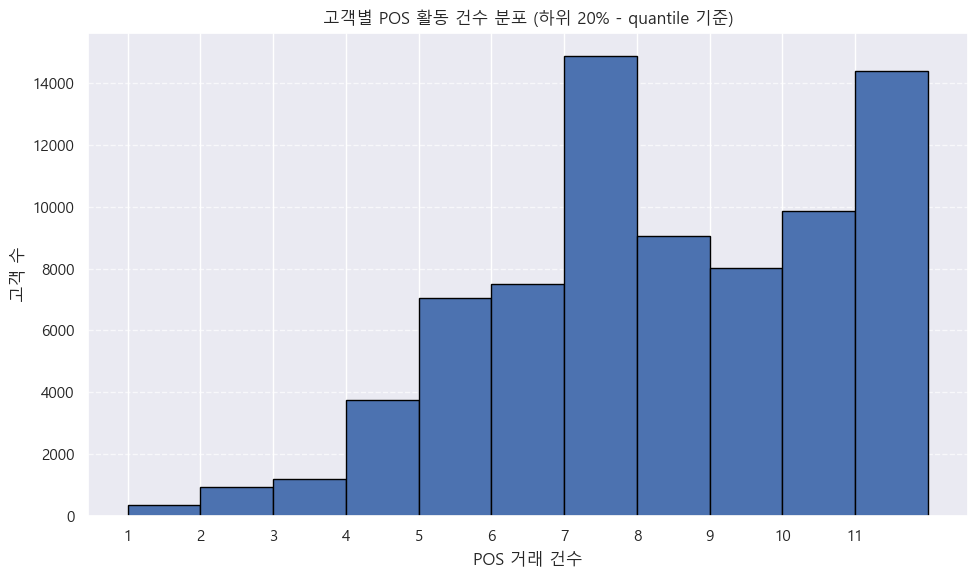

In [43]:
# 고객별 POS 활동 건수
n_pos = pos.groupby('SK_ID_CURR').size().reset_index(name='N_POS')

# 1. 하위 20% 기준값 계산
cutoff_pos = n_pos['N_POS'].quantile(0.2)
print(f"하위 20% 컷오프 (POS): {cutoff_pos}")

# 2. 플래그 생성 (하위 20%)
n_pos['IS_LOW_POS_ACTIVITY'] = (n_pos['N_POS'] <= cutoff_pos).astype(int)

# 3. 하위 20% 고객만 필터링
low_20_pos_users = n_pos[n_pos['IS_LOW_POS_ACTIVITY'] == 1]

# 4. 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(low_20_pos_users['N_POS'], 
         bins=range(int(low_20_pos_users['N_POS'].min()), int(cutoff_pos) + 2), 
         edgecolor='black')
plt.title('고객별 POS 활동 건수 분포 (하위 20% - quantile 기준)')
plt.xlabel('POS 거래 건수')
plt.ylabel('고객 수')
plt.xticks(range(int(low_20_pos_users['N_POS'].min()), int(cutoff_pos) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

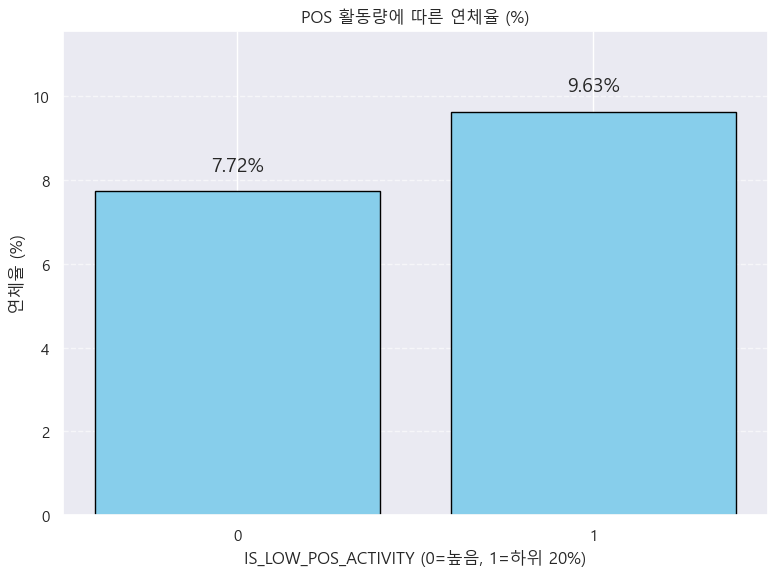

In [44]:
# 1. 데이터 병합 (d는 application_train.csv)
n_pos = n_pos.merge(d[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

# 2. 연체율 계산
grouped = n_pos.groupby('IS_LOW_POS_ACTIVITY')['TARGET'].agg(
    total='count',
    bads='sum'
).reset_index()

grouped['DEFAULT_RATE'] = (grouped['bads'] / grouped['total']) * 100

# 3. 막대그래프 시각화
plt.figure(figsize=(8, 6))
plt.bar(grouped['IS_LOW_POS_ACTIVITY'].astype(str), grouped['DEFAULT_RATE'],
        color='skyblue', edgecolor='black')

plt.title('POS 활동량에 따른 연체율 (%)')
plt.xlabel('IS_LOW_POS_ACTIVITY (0=높음, 1=하위 20%)')
plt.ylabel('연체율 (%)')
plt.ylim(0, grouped['DEFAULT_RATE'].max() * 1.2)

# 막대 위에 숫자 표시
for idx, val in enumerate(grouped['DEFAULT_RATE']):
    plt.text(idx, val + 0.5, f"{val:.2f}%", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- 0 : 80% 이고 연체율은 7.72%
- 1 : 20% 이고 연체율은 9.63%

In [45]:
n_pos['N_POS'].describe()

count    337252.000000
mean         29.655445
std          24.531971
min           1.000000
25%          12.000000
50%          22.000000
75%          39.000000
max         295.000000
Name: N_POS, dtype: float64

In [46]:
# 병합 전에 중복 컬럼 제거
if 'IS_LOW_POS_ACTIVITY' in pos.columns:
    pos.drop(columns=['IS_LOW_POS_ACTIVITY'], inplace=True)

# 병합
pos = pos.merge(n_pos[['SK_ID_CURR', 'IS_LOW_POS_ACTIVITY']], on='SK_ID_CURR', how='left')

# 결측값 처리
pos['IS_LOW_POS_ACTIVITY'] = pos['IS_LOW_POS_ACTIVITY'].fillna(0).astype(int)

In [47]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,IS_LONG_TERM_ACTIVE_KPI,IS_MORTGAGE_LOAN_KPI,IS_CAR_LOAN_KPI,IS_MICRO_LOAN_KPI,IS_RECENT_UPDATE_KPI,HAS_HIGH_RISK_DEBT,IS_LOW_EXTERNAL_CREDIT,FIRST_LOAN_MONTH,LOAN_HISTORY_MONTHS,LOAN_HISTORY_YEARS
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk,0,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk,0,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk,0,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk,0,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,0.363636,0.0,0.0,0.000000,0.545455,Non-High Risk,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,...,0.000000,0.0,0.0,0.666667,0.666667,Non-High Risk,0,NaN,NaN,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,...,0.545455,0.0,0.0,0.000000,0.272727,Non-High Risk,0,NaN,NaN,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,...,0.545455,0.0,0.0,0.000000,0.272727,Non-High Risk,0,NaN,NaN,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,...,0.161290,0.0,0.0,0.387097,0.419355,Non-High Risk,0,NaN,NaN,NaN


In [48]:
bureau_b

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,IS_OVERDUE,OVERDUE_RATE_36M,MAX_OVERDUE_STREAK_36M,HAS_BAD_STATUS_36M,MAX_STATUS_36M,AVG_STATUS_36M
0,5715448,0,C,0,0.0,0.0,0.0,0.0,0.0
1,5715448,-1,C,0,0.0,0.0,0.0,0.0,0.0
2,5715448,-2,C,0,0.0,0.0,0.0,0.0,0.0
3,5715448,-3,C,0,0.0,0.0,0.0,0.0,0.0
4,5715448,-4,C,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
27299920,5041336,-47,X,0,0.0,0.0,0.0,0.0,0.0
27299921,5041336,-48,X,0,0.0,0.0,0.0,0.0,0.0
27299922,5041336,-49,X,0,0.0,0.0,0.0,0.0,0.0
27299923,5041336,-50,X,0,0.0,0.0,0.0,0.0,0.0


In [49]:
pos

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,IS_POS_OVERDUE,IS_WRITTEN_OFF,IS_ACTIVE_POS,IS_COMPLETED_POS,IS_REPEATED_CONTRACT,IS_LONG_TERM_LOAN,IS_OVERDUE_SHORT,IS_OVERDUE_LONG,IS_LOW_POS_ACTIVITY
0,1803195,182943,-31,48.0,45.0,Active,0,0,0,0,1,0,1,1,0,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0,0,0,1,0,1,1,0,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0,0,0,1,0,1,0,0,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0,0,0,1,0,1,1,0,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,0,0,1,0,1,0,0,1,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,0,0,1,0,1,0,0,1,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,0,0,1,0,1,0,0,1,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,0,0,1,0,1,0,0,1,0


In [50]:
# 저장하기
bureau.to_csv("bureau_KPI.csv", index=False)

In [51]:
# 저장하기
bureau_b.to_csv("bureau_b_KPI.csv", index=False)

In [52]:
# 저장하기
pos.to_csv("pos_KPI.csv", index=False)